In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

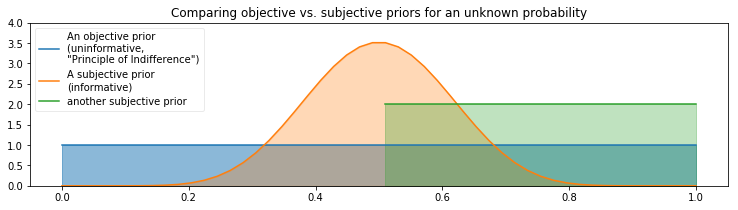

In [2]:
figsize(12.5, 3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1)
y1, y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10, 10)

p = plt.plot(x, y1,  label='An objective prior \n(uninformative, \n"Principle of Indifference")')
plt.fill_between(x, 0, y1, color = p[0].get_color(), alpha=0.3)
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x, y2, label = "A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x[25:], 2*np.ones(25), label="another subjective prior")
plt.fill_between(x[25:], 0, 2, color=p[0].get_color(), alpha=0.3)

plt.ylim(0,4)
leg = plt.legend(loc="upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability")

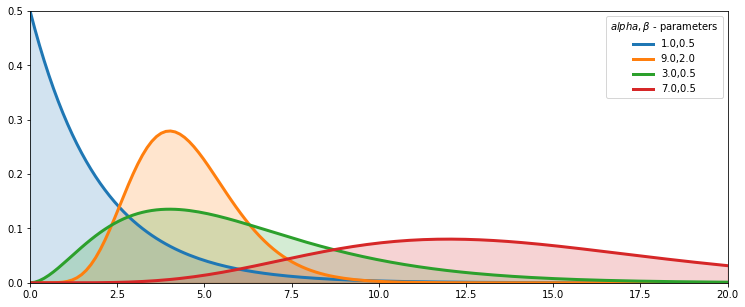

In [3]:
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001, 20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label="%.1f,%.1f" % (alpha,beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$alpha, \beta$ - parameters")

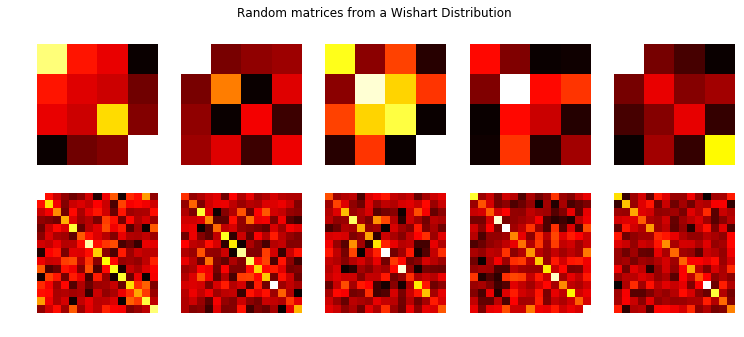

In [4]:
n = 4
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    if i >= 5:
        n = 15
    plt.imshow(stats.wishart.rvs(n+1, np.eye(n)), interpolation="none", cmap="hot")
    ax.axis("off")

plt.suptitle("Random matrices from a Wishart Distribution")

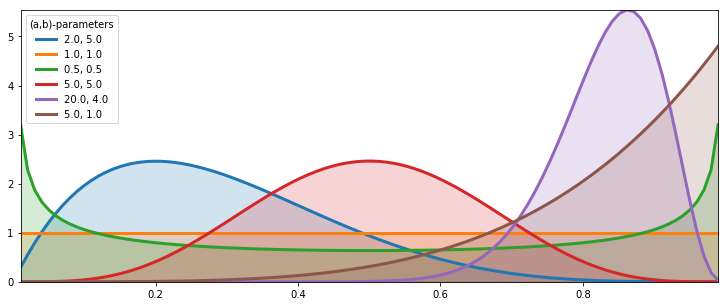

In [5]:
figsize(12.5, 5)

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, 0.99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label="%.1f, %.1f" % (a,b), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc='upper left', title="(a,b)-parameters")

In [8]:
rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
    
    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
    
    def sample_bandits(self, n=1):
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            # sample the chosen bandit
            result = self.bandits.pull(choice)
            
            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice
        
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [12]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color = c, alpha=alpha,  label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]), colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

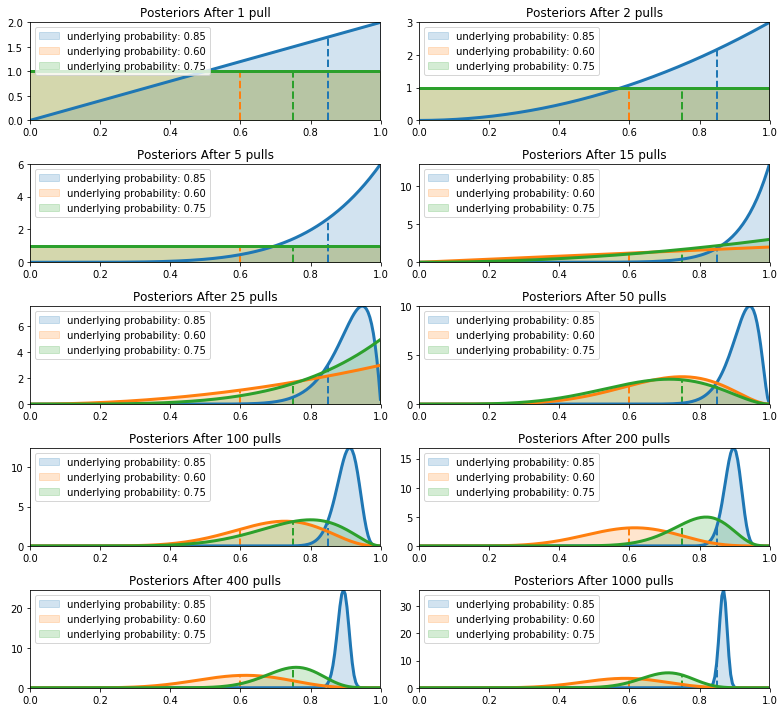

In [14]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1,1,3,10,10,25,50,100,200,600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend()
    plt.autoscale(tight=True)
plt.tight_layout()